# 0.0 Imports

### 0.1 Helper Libs

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from matplotlib import gridspec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import pickle

### 0.2 Loading Data

In [114]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

pd.options.display.max_columns = None

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

### 1.1 Renaming Columns

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [6]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [7]:
print( 'Number of Rows {}'.format(df1.shape[0]))
print( 'Number of Columns {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Columns 18


### 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### 1.4 Checking Null Values

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fill Out NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x) 
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

### 1.6 Fix Datatypes

In [11]:
df1.competition_open_since_month = df1.competition_open_since_month.astype(int)
df1.competition_open_since_year = df1.competition_open_since_year.astype(int)
df1.promo2_since_week = df1.promo2_since_week.astype(int)
df1.promo2_since_year = df1.promo2_since_year.astype(int)

### 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [13]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["Attribute", "Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
m

,Attribute,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

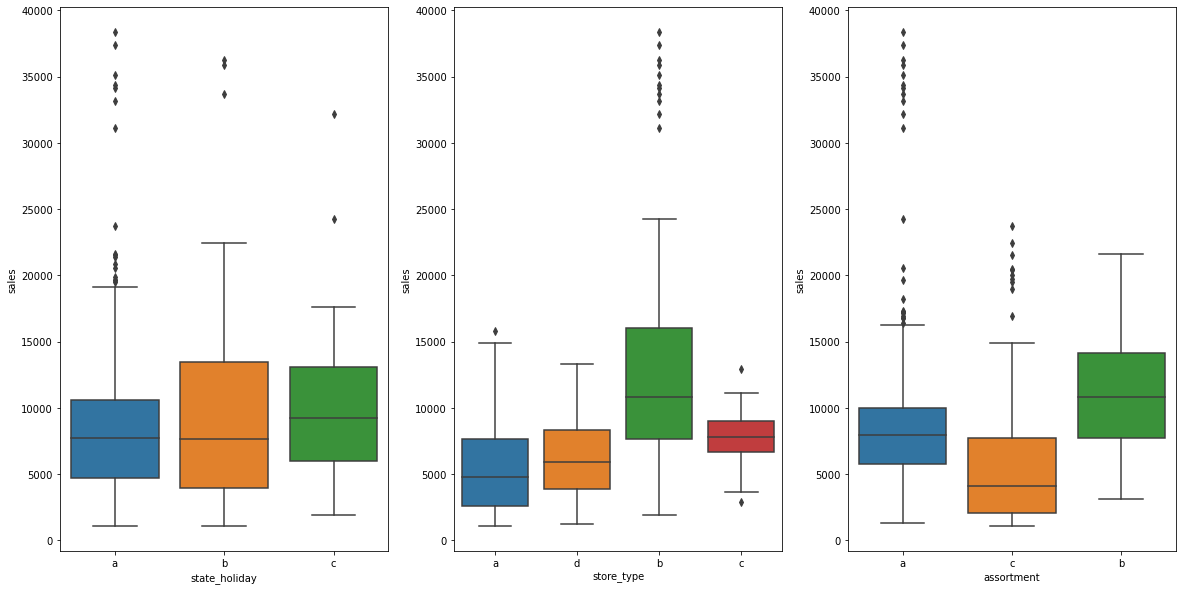

In [15]:
plt.rcParams['figure.figsize'] = (20, 10)
aux1 = df1[(df1['state_holiday'] != '0') & df1['sales'] > 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

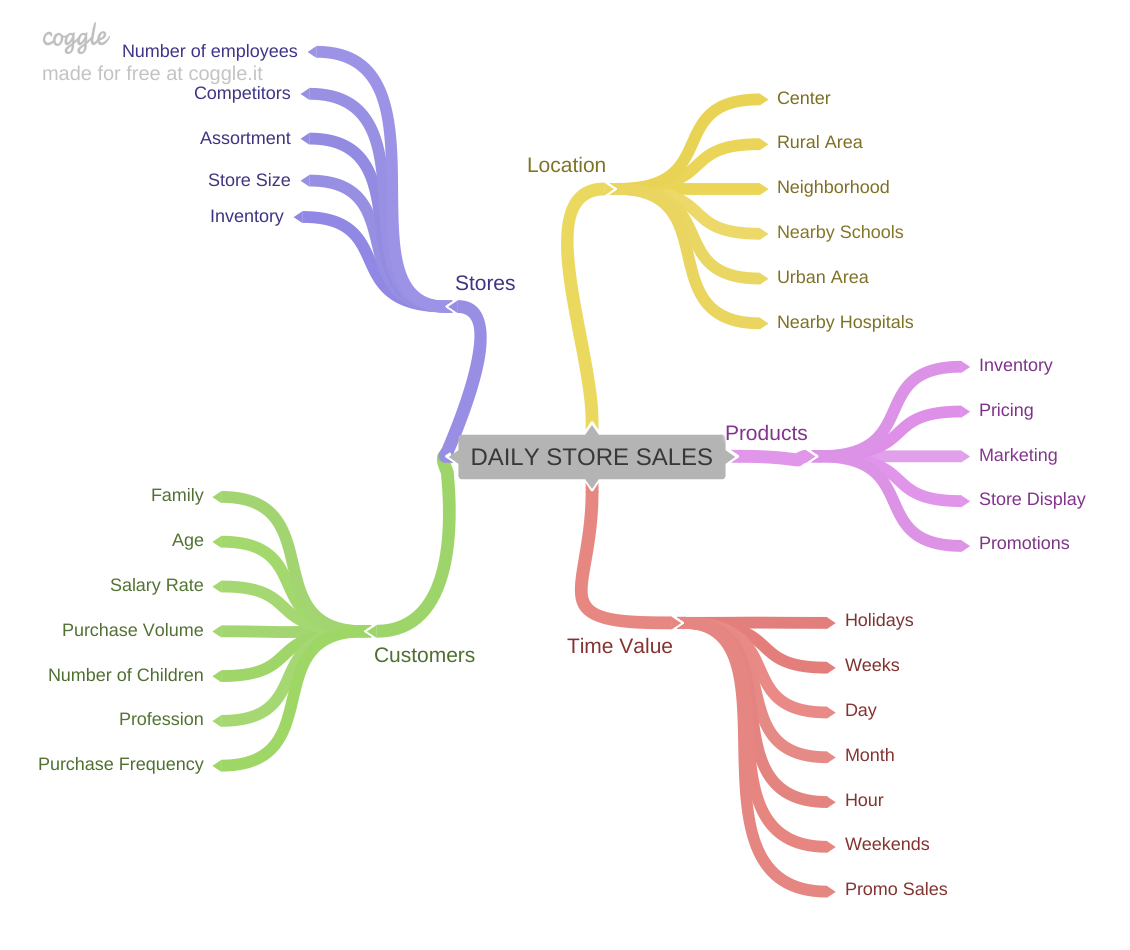

In [17]:
Image("img/MindMapHypothesis.png", width=500, height=500)

## 2.1 Hypothesis

### 2.1.1 Store Hypothesis

**1-** Stores with more employees should sell more.

**2-** Stores with more invenory should sell more.

**3-** More Sized stores should sell more.

**4-** Less Sized stores should sell less.

**5-** Stores with a broader product assortment should sell more.

**6-** Stores with a closer competition should sell less.

**7-** Stores with a closer competition for longer should sell less.


### 2.1.2 Product Hypothesis

**1-** Stores with more marketing spendings should sell more.

**2-** Stores more displayed products should sell more.

**3-** Stores with attractive pricing should sell more.

**4-** Stores with longer attractive pricing should sell more.

**5-** Stores with aggressive sales campaigns should sell more.

**6-** Stores with longer aggressive sales campaigns should sell more.

**7-** Stores with higher number of sales campaigns should sell more.

**8-** Stores with consecutive sales campaigns should sell more.

### 2.1.3 Time Hypothesis

**1-** Stores open during christmas holidays should have more sales.

**2-** Stores should sell more along the years.

**3-** Stores should sell more on the second semester of years.

**4-** Stores should sell more after the 10th of each month.

**5-** Stores should sell less on weekends.

**6-** Stores should sell less during scholar holidays


## 2.2 Final Hypothesis List

**1-** Stores with a broader product assortment should sell more.

**2-** Stores with a closer competition should sell less.

**3-** Stores with a closer competition for longer should sell more.

**4-** Stores with longer active sales campaigns should sell more.

**5-** Stores with higher number of sales campaigns should sell more.

**6-** Stores with consecutive sales campaigns should sell more.

**7-** Stores open during christmas holidays should have more sales.

**8-** Stores should sell more along the years.

**9-** Stores should sell more on the second semester of years.

**10-** Stores should sell more after the 10th of each month.

**11-** Stores should sell less on weekends.

**12-** Stores should sell less during scholar holidays

## 2.3 Feature Engineering

In [18]:
df2.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [19]:
#year
df2['Year'] = df2['date'].dt.year

#month
df2['Month'] = df2['date'].dt.month

#day
df2['Day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'],month= x['competition_open_since_month'],day= 1), axis= 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c' else 'regular_day')

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


# 3.0 Variables Filtering

In [20]:
df3 = df2.copy()
df3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,basic,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,extended,1880.0,4,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,9260.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,extended,870.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


### 3.1 Rows Filtering

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Columns Selection

In [22]:
cols_drop = ['customers', 'promo_interval', 'open', 'month_map']
df3.drop(cols_drop, axis = 1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'Year',
       'Month', 'Day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Data Exploratory Analysis

In [24]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Response Variable

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

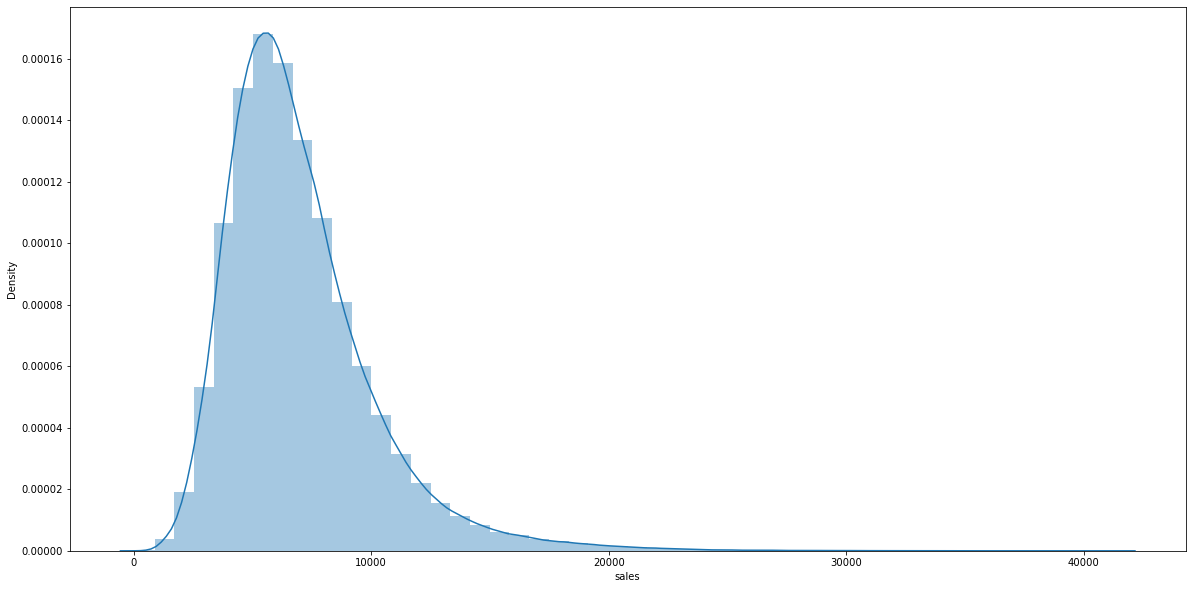

In [25]:
sns.distplot(df4['sales'])

#### 4.1.2 Numerical Variable

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


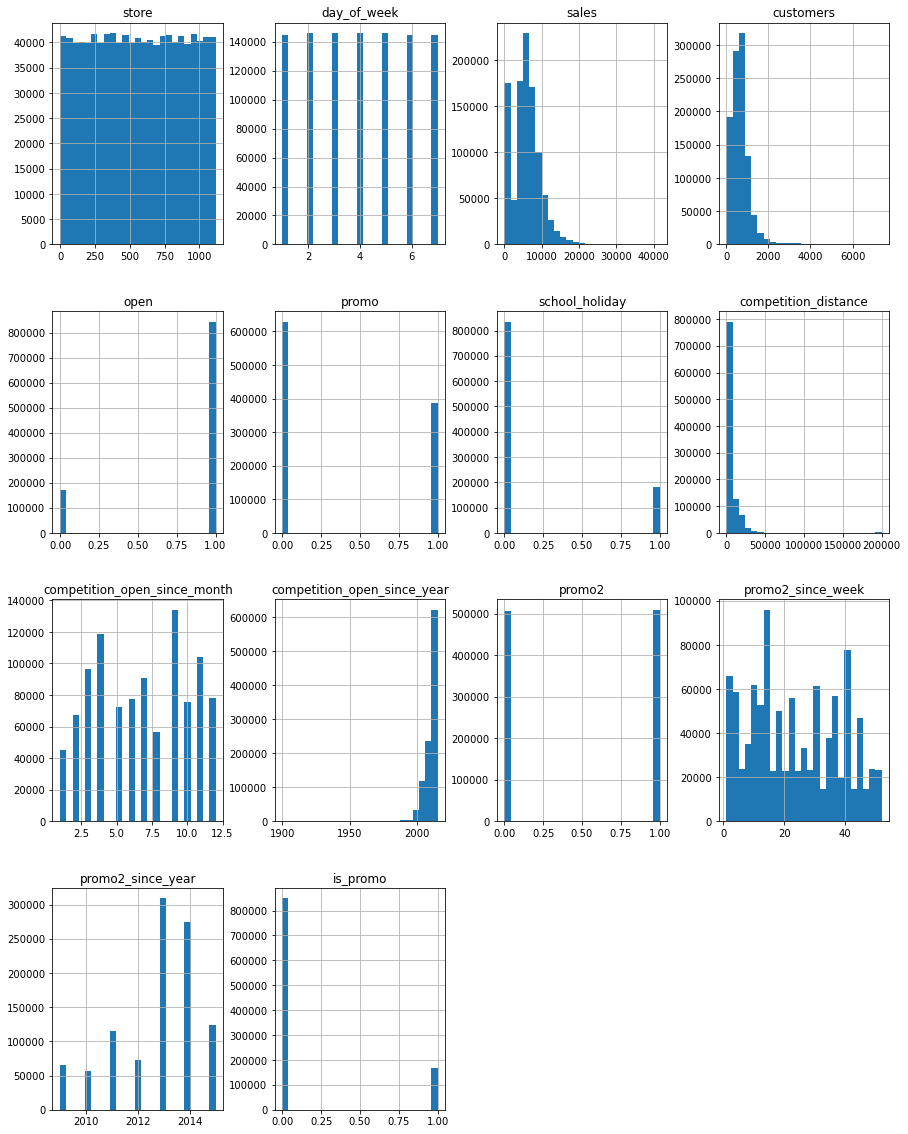

In [26]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_attributes.hist(bins = 25, ax = ax);

#### 4.1.3 Categorical Variable

In [27]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [28]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [29]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result 

<AxesSubplot:xlabel='sales', ylabel='Density'>

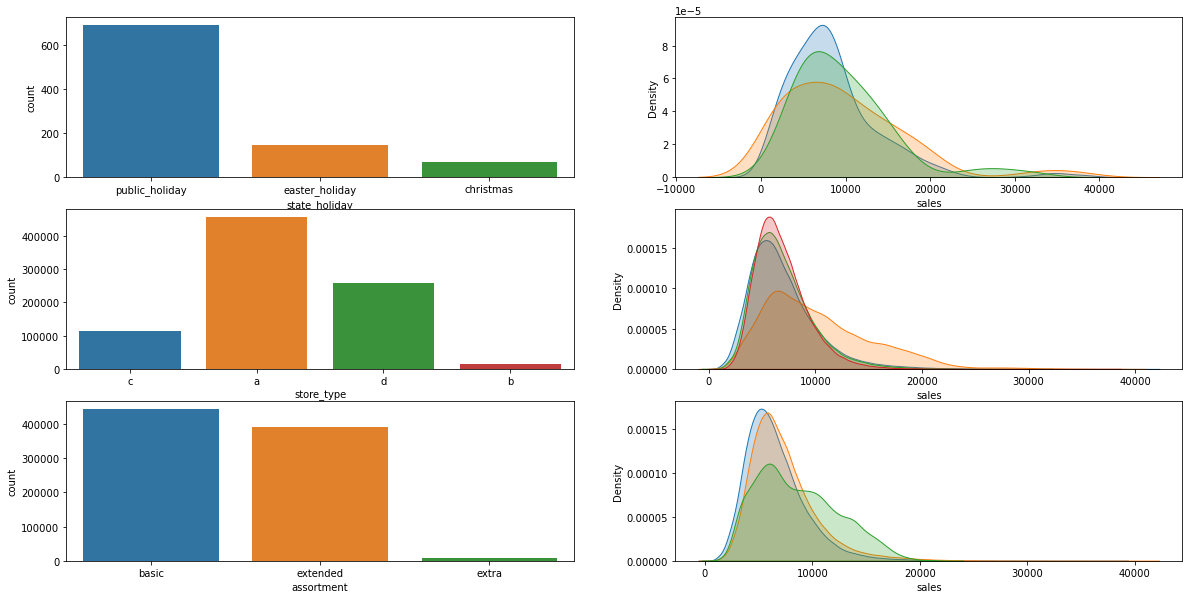

In [30]:
plt.rcParams['figure.figsize'] = (20, 10)
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


### 4.2 Bivariate Analysis

#### 1- Stores with a broader product assortment should sell more.

FALSE - Stores with a broader product assortment (EXTRA) sell LESS.

<AxesSubplot:xlabel='year_week'>

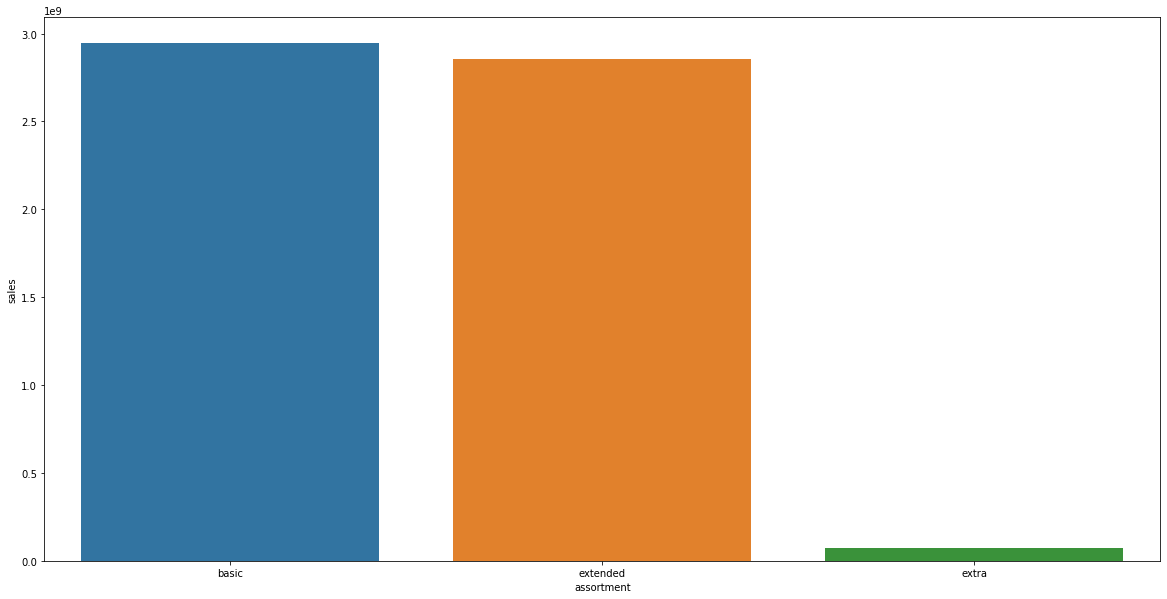

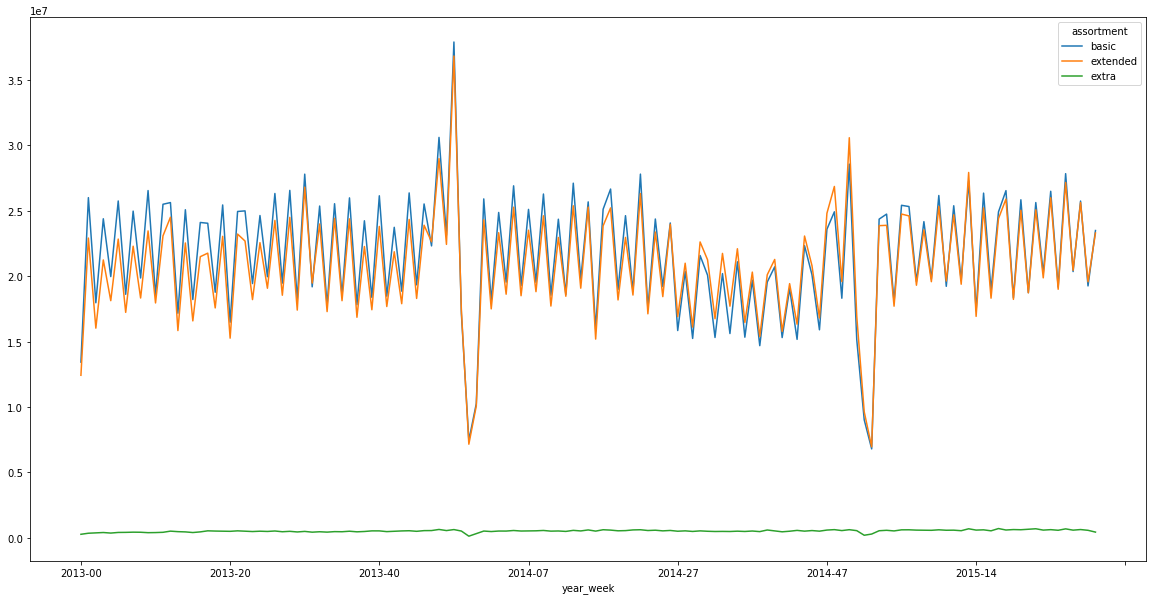

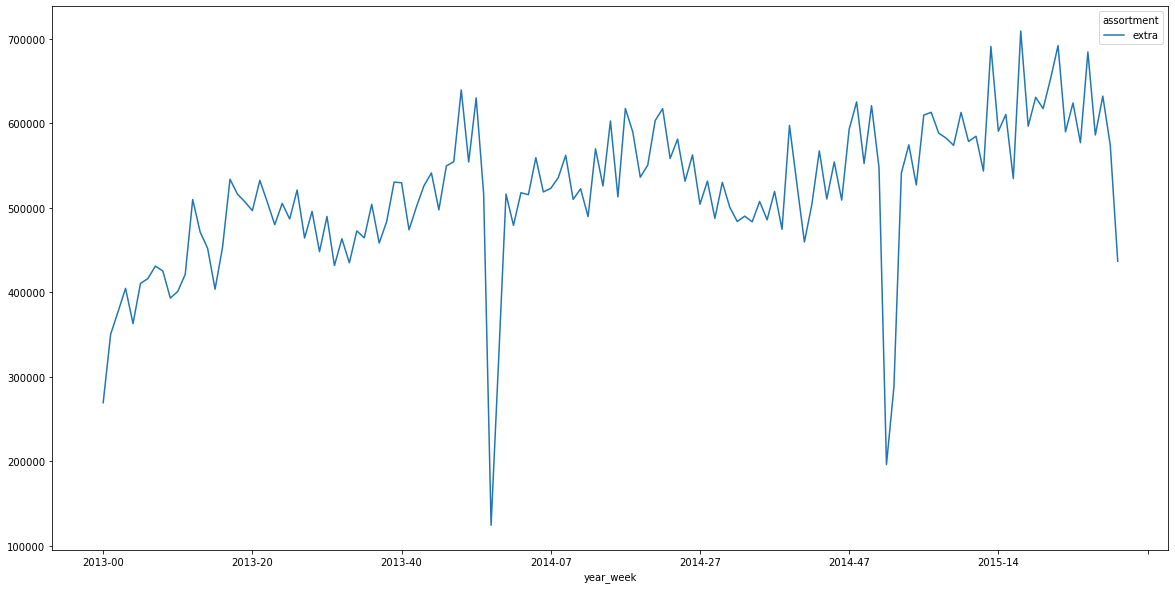

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

#### 2- Stores with a closer competition should sell less.

FALSE - Stores with a closer competition sell MORE.

<AxesSubplot:>

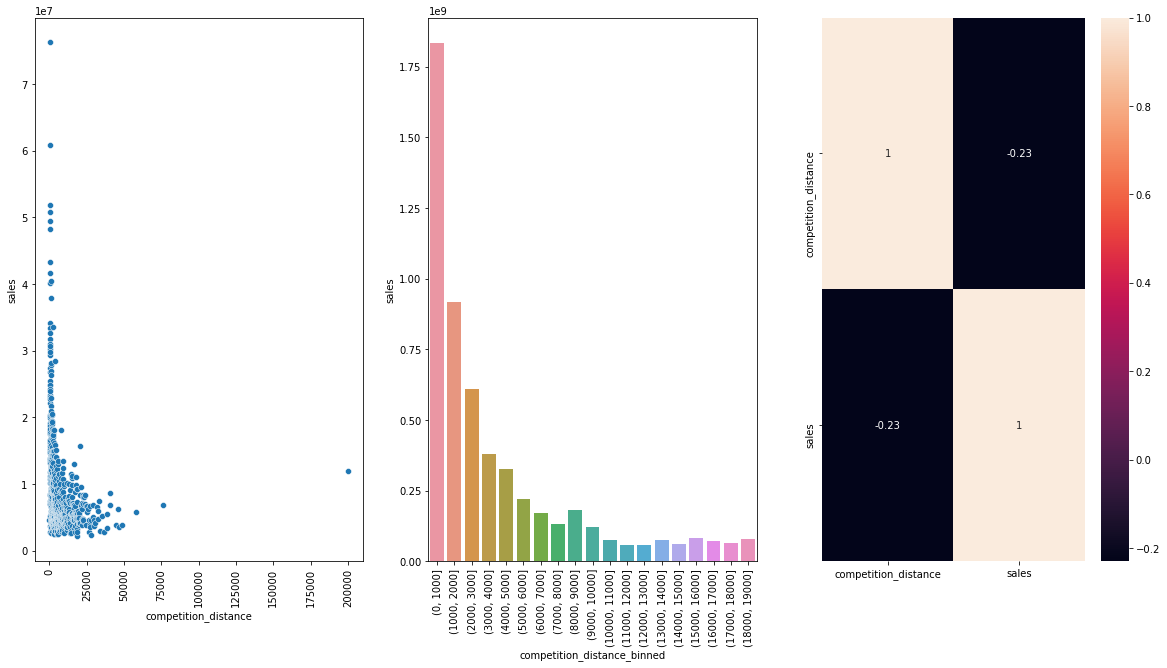

In [32]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data= aux1)
plt.xticks(rotation = 90)

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)

aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data= aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)



#### 3- Stores with a closer competition for longer period should sell more.

FALSE - Stores with a closer competition for longer period should sell LESS.

<AxesSubplot:>

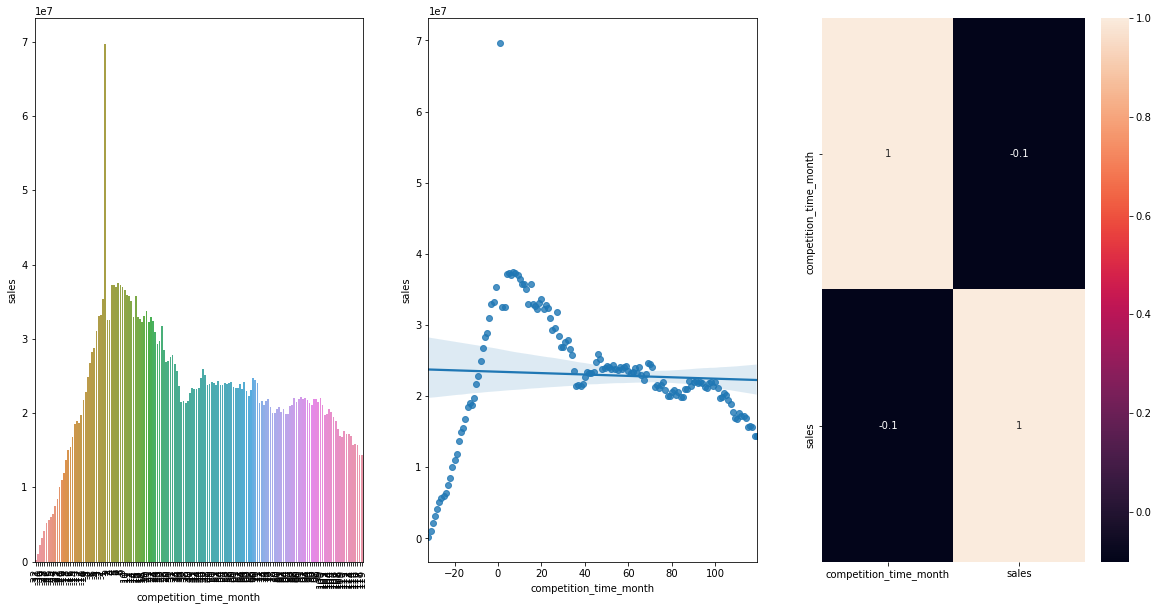

In [33]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1, 3, 1)
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.xticks(rotation = 90);
plt.subplot(1, 3, 2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= aux2)
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

#### 4- Stores with longer active sales campaigns should sell more.

FALSE - Stores with longer active sales campaigns sell LESS after a certain sales period.

<AxesSubplot:>

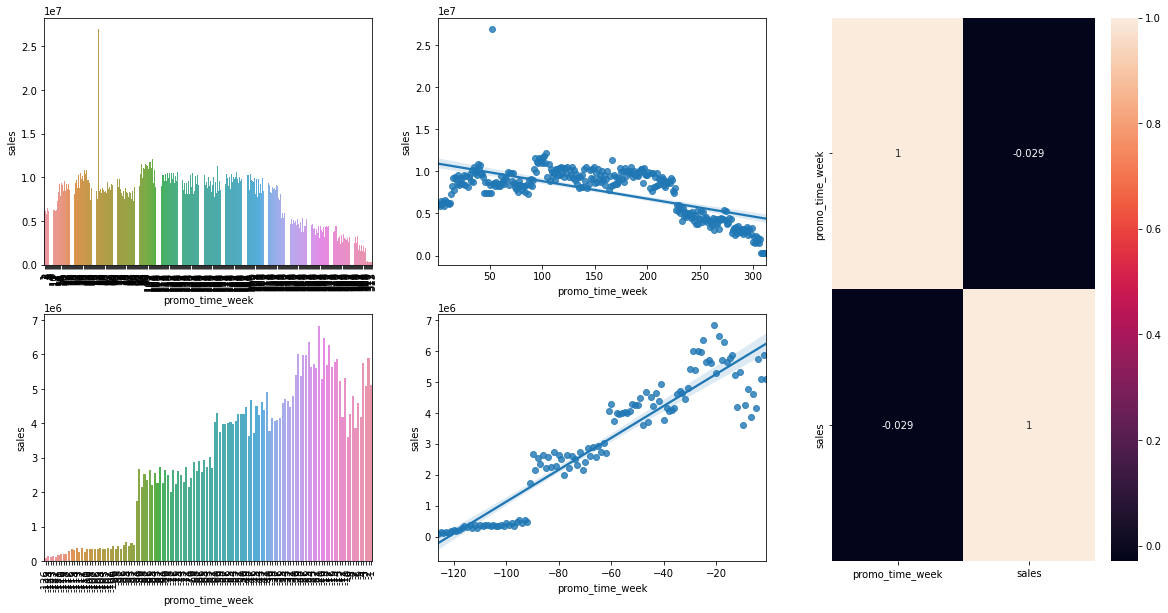

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3) 

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo sales
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo sales
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

#### 5- <s>Stores with higher number of sales campaigns should sell more.</s>

#### 6- Stores with consecutive sales campaigns should sell more.

FALSE - Stores with consecutive sales campaigns sell LESS.

In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


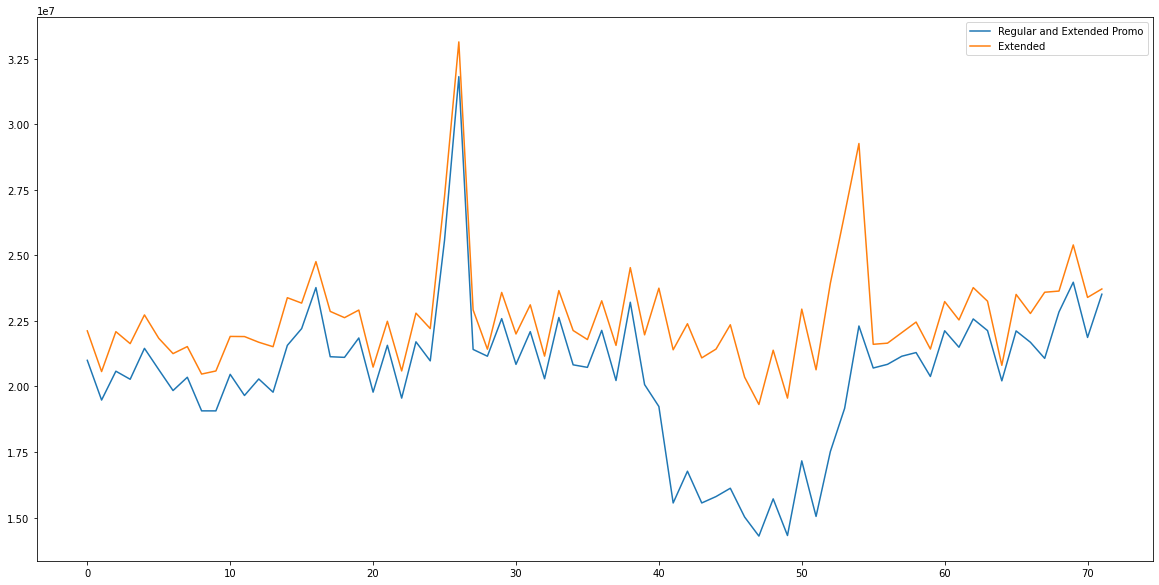

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels=['Regular and Extended Promo', 'Extended'])

#### 7- Stores open during christmas holidays should have more sales.

FALSE - Stores open during christmas holidays have LESS sales.

<AxesSubplot:xlabel='Year', ylabel='sales'>

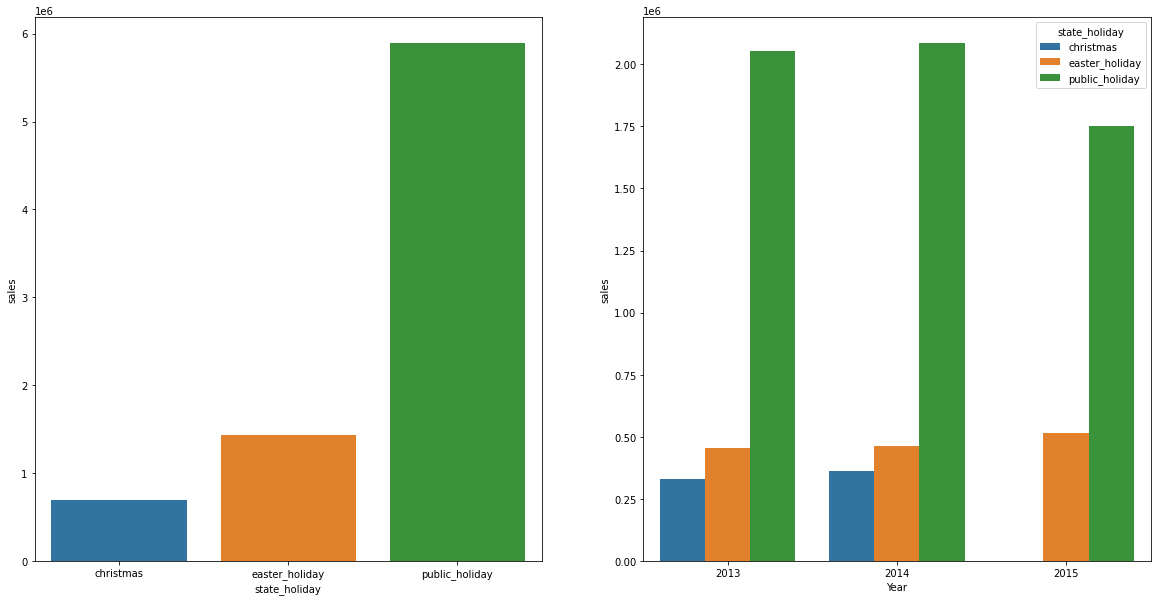

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x= 'state_holiday', y='sales', data= aux1)

aux2 = aux[['Year', 'state_holiday', 'sales']].groupby(['Year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x= 'Year', y='sales', hue= 'state_holiday', data= aux2)

#### 8- Stores should sell more along the years.

FALSE - Stores sell LESS along the years.

<AxesSubplot:>

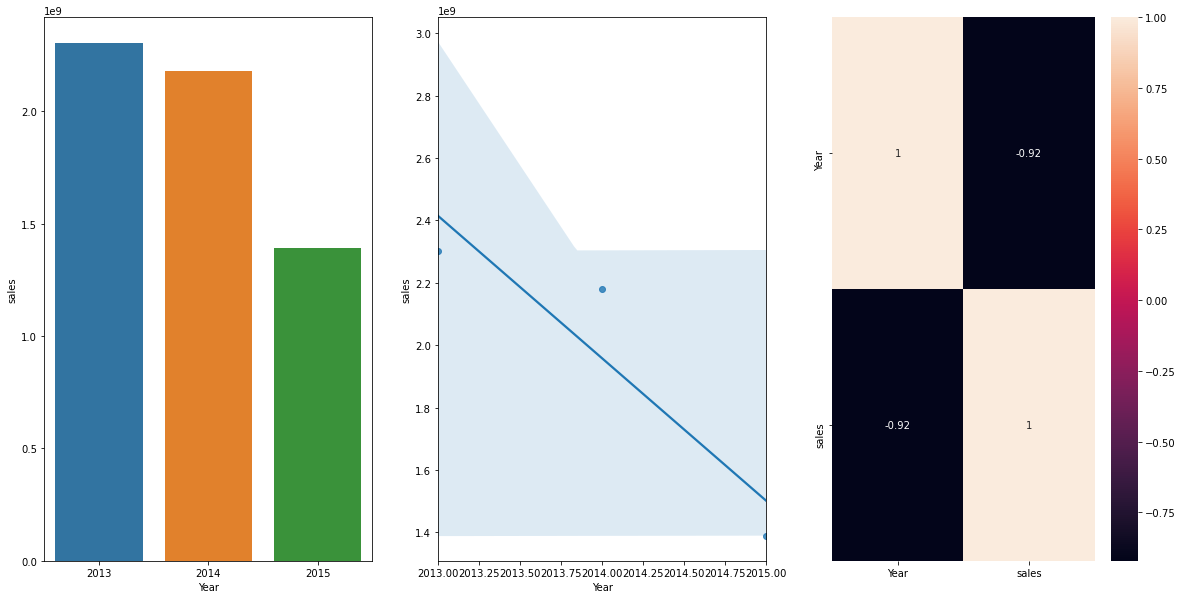

In [38]:
aux1 = df4[['Year', 'sales']].groupby("Year").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='Year', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='Year', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

#### 9- Stores should sell more on the second semester of years.

FALSE - Stores sell LESS on the second semester of years

<AxesSubplot:>

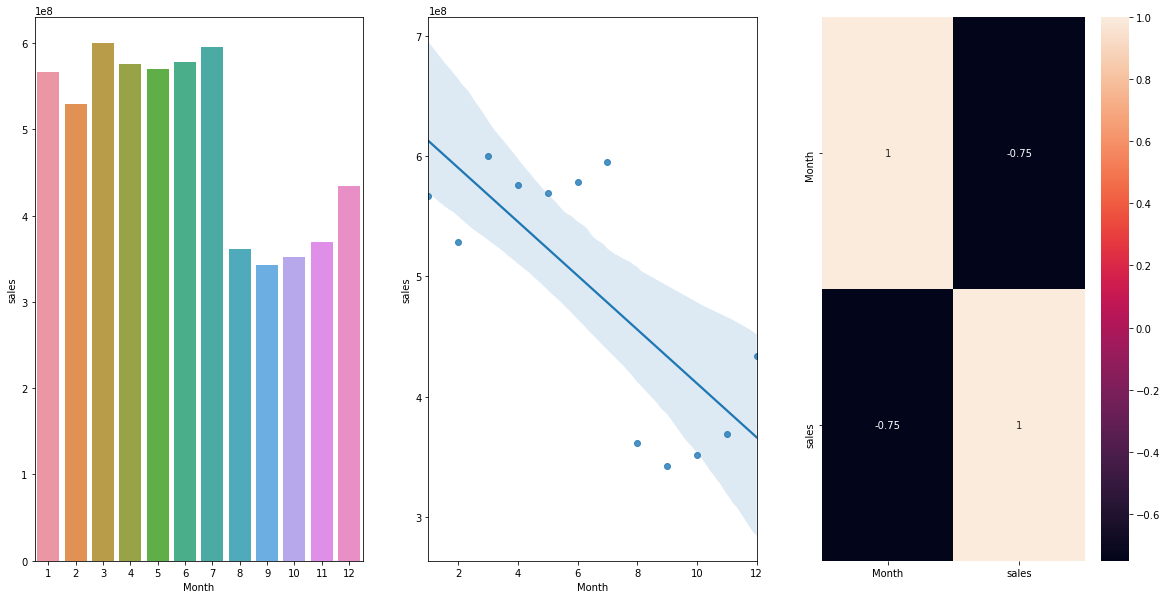

In [39]:
aux1 = df4[['Month', 'sales']].groupby("Month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='Month', y='sales', data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='Month', y='sales', data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

#### 10- Stores should sell more after the 10th day of each month.

TRUE - Stores sell MORE after the 10th of each month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

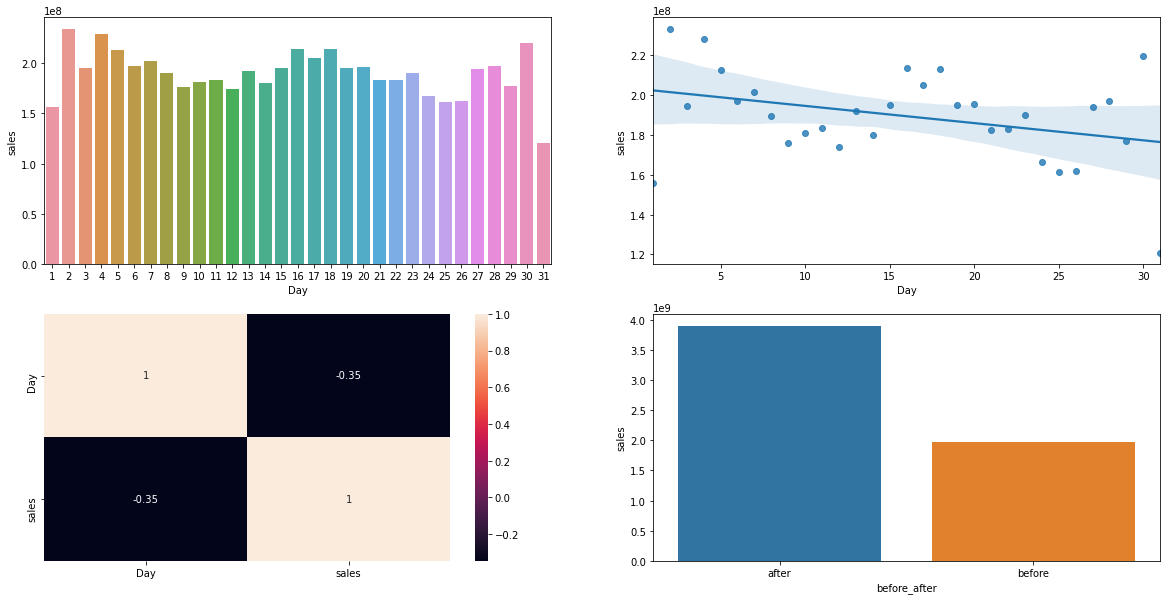

In [40]:
aux1 = df4[['Day', 'sales']].groupby("Day").sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='Day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='Day', y='sales', data=aux1);

plt.subplot(2,2,3);
sns.heatmap(aux1.corr(method='pearson'), annot = True)

aux1['before_after'] = aux1['Day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4);
sns.barplot(x= 'before_after', y= 'sales', data=aux2)

#### 11- Stores should sell less on weekends.

TRUE - Stores SELL less on weekends.

<AxesSubplot:>

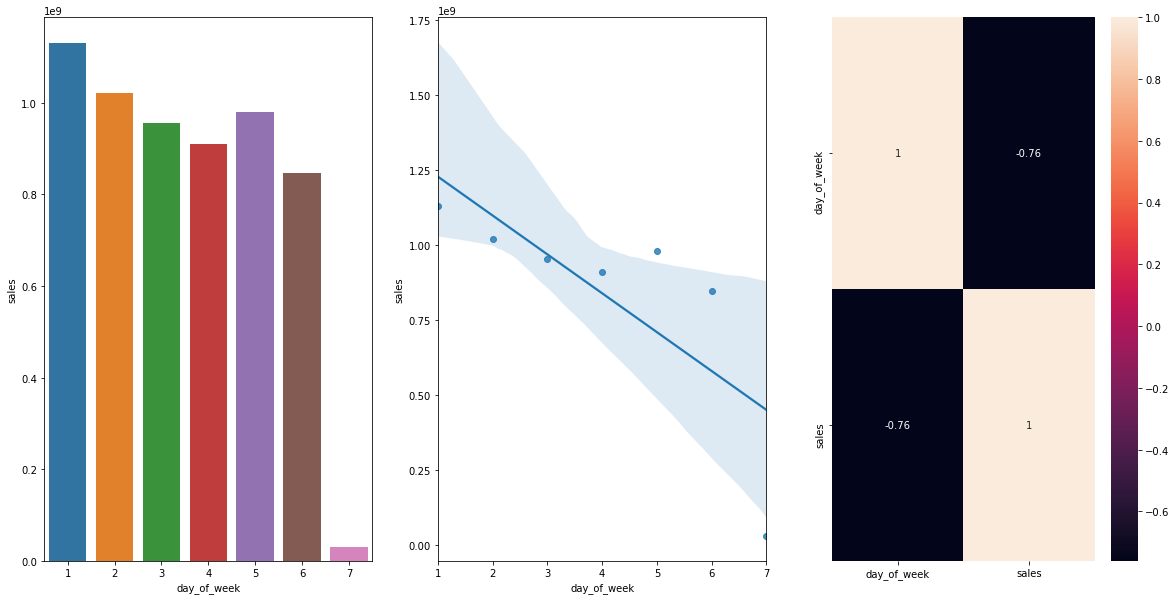

In [41]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

#### 12- Stores should sell less during scholar holiday

TRUE - Stores SELL less during scholar holiday, except on August.

<AxesSubplot:xlabel='Month', ylabel='sales'>

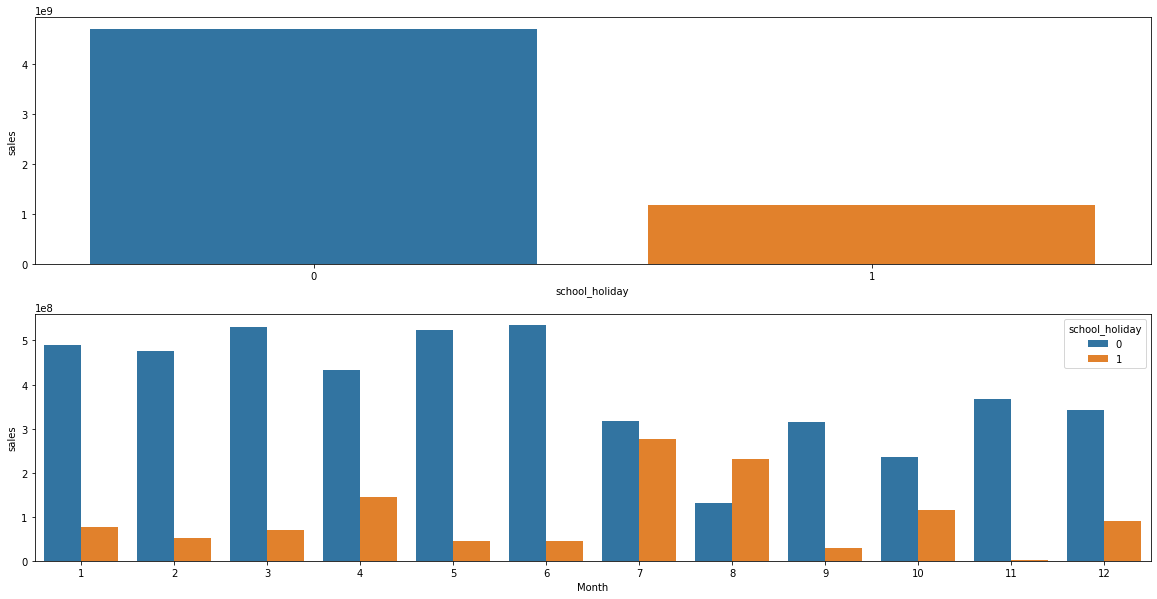

In [42]:
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1)

aux2= df4[['Month', 'school_holiday', 'sales']].groupby(['school_holiday', 'Month']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x= 'Month', y= 'sales', hue= 'school_holiday', data= aux2)

### 4.3 Multivariate Analysis

#### 4.3.1 Numerical Attributes

<AxesSubplot:>

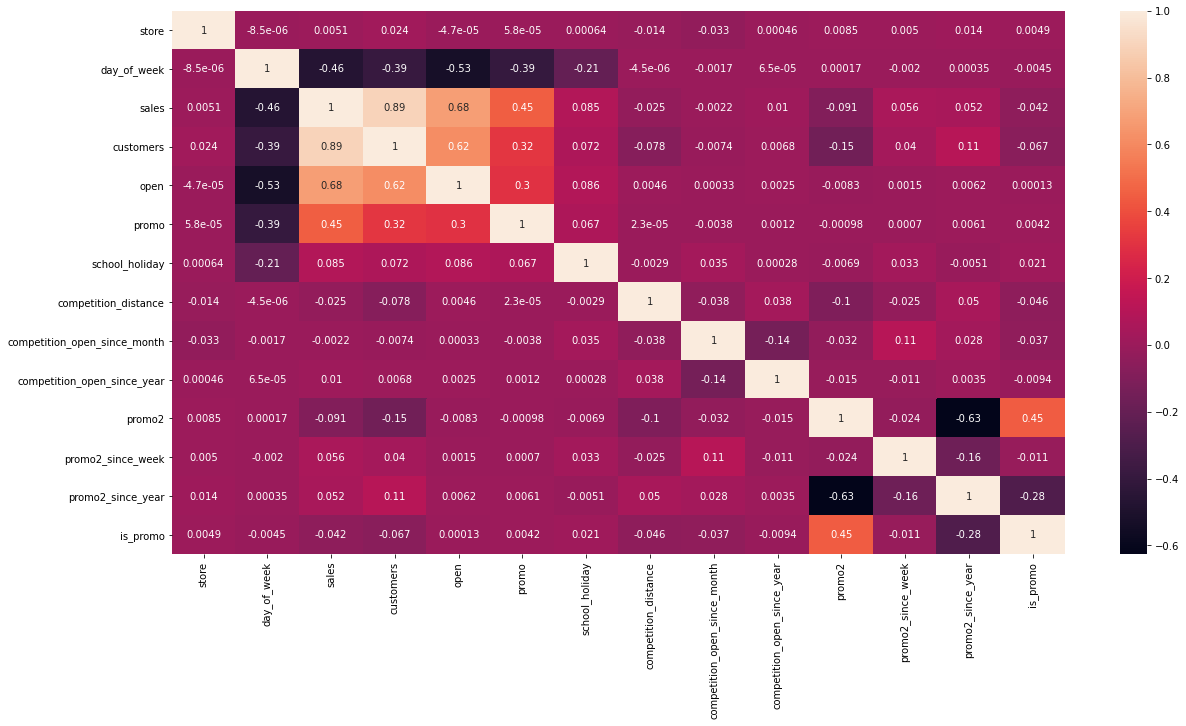

In [43]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot= True)

#### 4.3.1 Categorical Attributes

In [44]:
#filtering categorical columns
a = df4[['state_holiday', 'store_type', 'assortment']]
a.head(5)

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


In [45]:
#cramer V function with biased correction
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n= cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / (min (kcorr-1, rcorr-1)))

<AxesSubplot:>

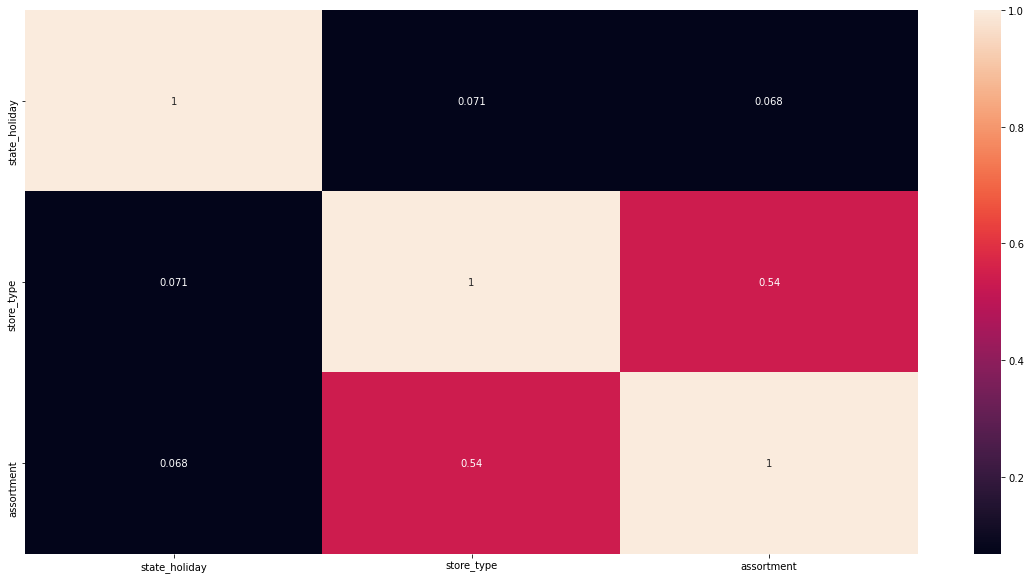

In [46]:
#Cramer V Calculations
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#V-cramer correlation dataframe
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [47]:
df5 = df4.copy()

### 5.1 Normalization

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


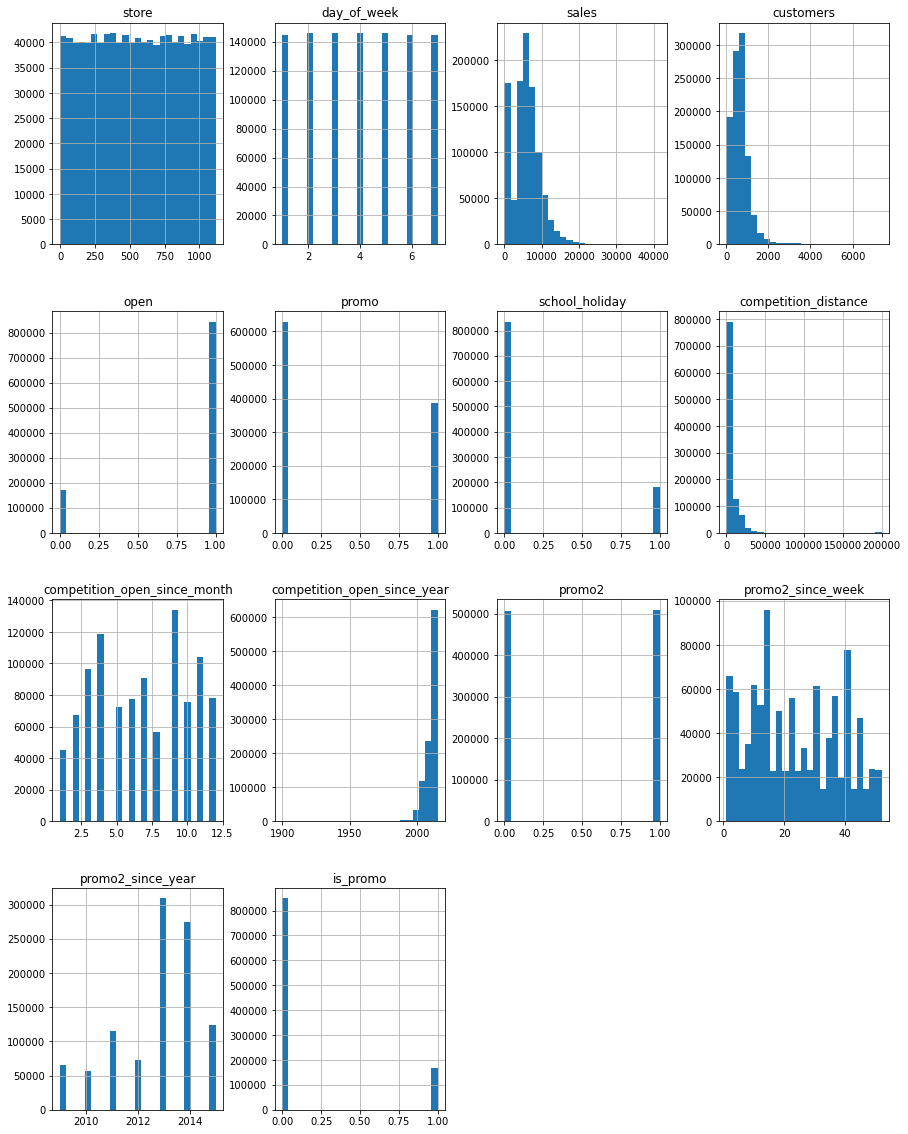

In [48]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_attributes.hist(bins = 25, ax = ax);

### 5.2 Rescaling

In [49]:
df5.select_dtypes(include = ['int64', 'float64'])
df5.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,Year,Month,Day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [50]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['competition_time_month']].values)

pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['Year'] = mms.fit_transform(df5[['Year']].values)

pickle.dump(rs, open('parameter/year_scaler.pkl', 'wb'))

### 5.3 Transformation

#### 5.3.1 Encoding

In [51]:
#state_holiday - ONE HOT ENCODING(DUMMY)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=["state_holiday"])

#store type - LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - ORDINAL ENCODING
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Responsive Variable Transformation

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

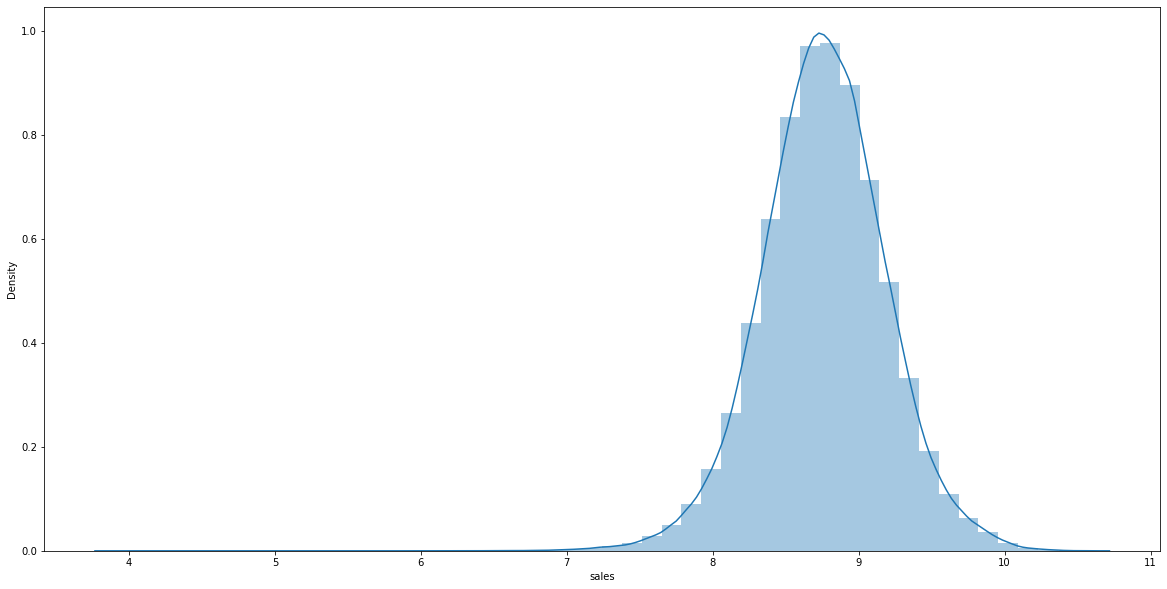

In [52]:
df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

#### 5.3.3 Nature Transformation

In [53]:
#month
df5['month_sin'] = df5['Month'].apply(lambda x: np.sin (x* (2. * np.pi/12)))
df5['month_cos'] = df5['Month'].apply(lambda x: np.cos (x* (2. * np.pi/12)))
#day
df5['day_sin'] = df5['Day'].apply(lambda x: np.sin (x* (2. * np.pi/30)))
df5['day_cos'] = df5['Day'].apply(lambda x: np.cos (x* (2. * np.pi/30)))
#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x* (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x* (2. * np.pi/52)))
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x* (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x* (2. * np.pi/7)))

# 6.0 Feature Selection

In [54]:
df6 = df5.copy()

In [55]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map',
       'is_promo', 'Year', 'Month', 'Day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')

### 6.1 Split Dataframe into training and test dataset

In [56]:
cols_drop = ['week_of_year', 'Day', 'Month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'promo_interval', 'month_map', 'customers', 'open']
df6 = df6.drop(cols_drop, axis =1)

In [57]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [58]:
#TRAINING DATASET
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#TEST DATASET
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

### 6.2 Boruta Algorithm as Feature Selector

In [59]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [60]:
#define training and test dataset for Boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()
#define random forest regressor
rf = RandomForestRegressor(n_jobs=-1)
#define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


#### 6.2.1 Best Features from Boruta

In [61]:
cols_selected = boruta.support_.tolist()
#Best Features Boruta
x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#Not Selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [62]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [63]:
cols_not_selected_boruta

['Year',
 'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin']

### 6.2 Combining Boruta Selected with Manual Picked Features

In [64]:
#Features checkpoint
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance', 
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2', 
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month', 
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos', 
                        'month_sin',
                        'month_cos',
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_sin', 
                        'week_of_year_cos']
#columns to re-add
feat_to_add = ['date', 'sales']

#final features

cols_selected_boruta_full = ['store','promo','store_type',  'assortment', 'competition_distance',  'competition_open_since_month', 
                        'competition_open_since_year',  'promo2',  'promo2_since_week',  'promo2_since_year', 
                        'competition_time_month',  'promo_time_week', 'day_of_week_sin',  'day_of_week_cos',  'month_sin',
                        'month_cos', 'day_sin',  'day_cos',  'week_of_year_sin', 'week_of_year_cos', 'date', 'sales']

# 7.0 Machine Learning Modelling

In [65]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
x_train = X_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]

x_training = X_train[ cols_selected_boruta_full ]


### 7.1 Average Model

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'mae': mae,
                          'mape': mape,
                          'rmse': rmse}, index = [0])

In [68]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how= 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance 

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model

In [69]:
from sklearn.linear_model import LinearRegression, Lasso

In [70]:
#model
lr = LinearRegression().fit(x_train, y_train)
#prediction
yhat_lr = lr.predict(x_test)
#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr)) 
lr_result

,Model Name,mae,mape,rmse
0,Linear Regression,1867.325182,0.292692,2671.685987


### 7.3 Linear Regression Regularized Model - Lasso

In [71]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)
#prediction
yhat_lrr = lrr.predict(x_test)
#performance
lrr_result = ml_error('Linear Regression-Lasso', np.expm1(y_test), np.expm1(yhat_lrr)) 
lrr_result

,Model Name,mae,mape,rmse
0,Linear Regression-Lasso,1891.704881,0.289106,2744.451737


### 7.4 Random Forest Regressor

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,mae,mape,rmse
0,Random Forest Regressor,686.402119,0.100409,1023.636294


### 7.5 XGBoost Regressor

In [74]:
import xgboost as xgb

In [75]:
#model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                            n_estimators = 100,
                            eta = 0.01,
                            max_depth = 10,
                            subsample = 0.7,
                            colsample_bytee = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,mae,mape,rmse
0,XGBoost Regressor,857.140063,0.123586,1262.036877


### 7.6 Models Performance Comparison

In [76]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('rmse')

,Model Name,mae,mape,rmse
0,Random Forest Regressor,686.402119,0.100409,1023.636294
0,XGBoost Regressor,857.140063,0.123586,1262.036877
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.325182,0.292692,2671.685987
0,Linear Regression-Lasso,1891.704881,0.289106,2744.451737


### 7.7 Cross Validation

In [77]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose == True:
            print('\n KFold Number: {}'.format(k))
        #validation start and end date
        validation_start_date = x_training.date.max() - datetime.timedelta(k*6*7)
        validation_end_date = x_training.date.max() - datetime.timedelta((k-1)*6*7)

        #filtering data set
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)
        #prediction
        yhat = m.predict(xvalidation)
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        print(m_result)
        #storing kfold iteration performance 
        mae_list.append( m_result['mae'])
        mape_list.append( m_result['mape'])
        rmse_list.append( m_result['rmse'])

    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

#### 7.7.1 Linear Regression CV

In [78]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

          Model Name          mae      mape         rmse
0  Linear Regression  2647.481646  0.311469  3822.559906
          Model Name          mae      mape         rmse
0  Linear Regression  1907.289556  0.327919  2575.906789
          Model Name          mae      mape         rmse
0  Linear Regression  1804.386413  0.304094  2523.417173
          Model Name          mae      mape         rmse
0  Linear Regression  2069.326605  0.285466  3001.617564
          Model Name          mae      mape         rmse
0  Linear Regression  1980.383658  0.283847  2840.660665


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.77+/-295.92,0.3+/-0.02,2952.83+/-468.58


#### 7.7.2 Lasso CV

In [79]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

  Model Name          mae      mape         rmse
0      Lasso  2751.445092  0.314447  3976.152858
  Model Name          mae     mape         rmse
0      Lasso  1846.851448  0.29114  2630.900853
  Model Name          mae      mape         rmse
0      Lasso  1808.433767  0.289097  2594.856002
  Model Name          mae      mape         rmse
0      Lasso  2160.643983  0.284632  3168.020404
  Model Name          mae      mape         rmse
0      Lasso  2014.533629  0.280721  2918.817489


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


#### 7.7.3 Random Forest CV

In [80]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = False)
rf_result_cv

                Model Name          mae      mape         rmse
0  Random Forest Regressor  1174.993389  0.145847  1739.801105
                Model Name         mae      mape         rmse
0  Random Forest Regressor  832.770958  0.127215  1243.339668
                Model Name         mae      mape        rmse
0  Random Forest Regressor  554.975735  0.088601  856.993748
                Model Name         mae      mape        rmse
0  Random Forest Regressor  860.182211  0.110404  1311.14639
                Model Name         mae      mape        rmse
0  Random Forest Regressor  702.241749  0.097827  1017.63155


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,825.03+/-205.8,0.11+/-0.02,1233.78+/-300.27


#### 7.7.4 XGBoost CV

In [81]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
xgb_result_cv

          Model Name          mae      mape         rmse
0  XGBoost Regressor  1316.482765  0.171423  1845.504022
          Model Name         mae      mape        rmse
0  XGBoost Regressor  929.641151  0.140858  1302.64511
          Model Name        mae      mape         rmse
0  XGBoost Regressor  839.46825  0.127955  1214.128487
          Model Name          mae      mape         rmse
0  XGBoost Regressor  1087.788112  0.140218  1611.922207
          Model Name         mae      mape         rmse
0  XGBoost Regressor  954.177221  0.129159  1356.696854


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1025.51+/-165.79,0.14+/-0.02,1466.18+/-231.25


### 7.8 Real Performance After Cross Validation

In [82]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.77+/-295.92,0.3+/-0.02,2952.83+/-468.58
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,825.03+/-205.8,0.11+/-0.02,1233.78+/-300.27
0,XGBoost Regressor,1025.51+/-165.79,0.14+/-0.02,1466.18+/-231.25


# 8.0 Hyperparameter Fine Tuning

### 8.1 Random Search 

In [83]:
import random
import pickle
import warnings

In [84]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [85]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

 KFold Number: 5
          Model Name          mae      mape         rmse
0  XGBoost Regressor  1073.650662  0.140025  1549.853301

 KFold Number: 4
          Model Name         mae      mape        rmse
0  XGBoost Regressor  838.551201  0.125766  1180.96627

 KFold Number: 3
          Model Name         mae      mape        rmse
0  XGBoost Regressor  686.541457  0.107087  1002.78023

 KFold Number: 2
          Model Name         mae      mape         rmse
0  XGBoost Regressor  958.358184  0.125323  1399.526721

 KFold Number: 1
          Model Name         mae      mape         rmse
0  XGBoost Regressor  789.350058  0.111212  1090.280233
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

 KFold Number: 5
          Model Name          mae      mape         rmse
0  XGBoost Regressor  1316.631095  0.16

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,869.29+/-134.48,0.12+/-0.01,1244.68+/-201.75
0,XGBoost Regressor,1128.92+/-137.77,0.16+/-0.01,1593.07+/-186.39
0,XGBoost Regressor,955.58+/-128.52,0.13+/-0.01,1353.43+/-175.31
0,XGBoost Regressor,921.55+/-147.48,0.13+/-0.02,1313.67+/-212.98
0,XGBoost Regressor,981.74+/-152.57,0.14+/-0.01,1394.63+/-214.3


### 8.2 Final Model

In [86]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
    }


In [87]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,mae,mape,rmse
0,XGBoost Regressor,655.933359,0.095963,949.684575


In [88]:
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [89]:
def mean_percentage_error (y, yhat):
    return np.mean((y - yhat) / y)

mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

mpe

0.0005395428972933638

# 9.0 Error Interpretation

In [90]:
X_test = df6[df6['date'] >= '2015-06-19']
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 9.1 Business Performance

In [91]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how= 'inner', on= 'store')
df92 = pd.merge(df91, df9_aux3, how= 'inner', on= 'store')


#scenarios
df92['best_scenario'] = df92['predictions'] + df92['MAE']
df92['worst_scenario'] = df92['predictions'] - df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']]
df92

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
0,1,159263.031250,159552.620764,158973.441736,289.589514,0.065003
1,2,179109.296875,179476.069699,178742.524051,366.772824,0.077036
2,3,260187.484375,260761.281072,259613.687678,573.796697,0.080695
3,4,341913.500000,342840.109599,340986.890401,926.609599,0.088257
4,5,169144.375000,169559.574770,168729.175230,415.199770,0.089790
...,...,...,...,...,...,...
1110,1111,178332.437500,178953.622809,177711.252191,621.185309,0.133457
1111,1112,334166.000000,335163.123971,333168.876029,997.123971,0.119236
1112,1113,235956.718750,236499.237793,235414.199707,542.519043,0.082760
1113,1114,758078.937500,760678.488651,755479.386349,2599.551151,0.111537


In [92]:
df92.sort_values('MAPE', ascending=False)

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
291,292,104071.562500,107363.759419,100779.365581,3292.196919,0.548740
908,909,236959.515625,244699.711022,229219.320228,7740.195397,0.528725
875,876,207861.062500,211811.555462,203910.569538,3950.492962,0.304386
721,722,356840.718750,358936.521893,354744.915607,2095.803143,0.279742
594,595,396543.968750,400129.618111,392958.319389,3585.649361,0.248405
...,...,...,...,...,...,...
561,562,735505.875000,736399.846157,734611.903843,893.971157,0.051135
732,733,636888.187500,637626.043128,636150.331872,737.855628,0.051009
1096,1097,454630.125000,455149.329067,454110.920933,519.204067,0.049484
989,990,232583.593750,232866.752375,232300.435125,283.158625,0.044377


<AxesSubplot:xlabel='store', ylabel='MAPE'>

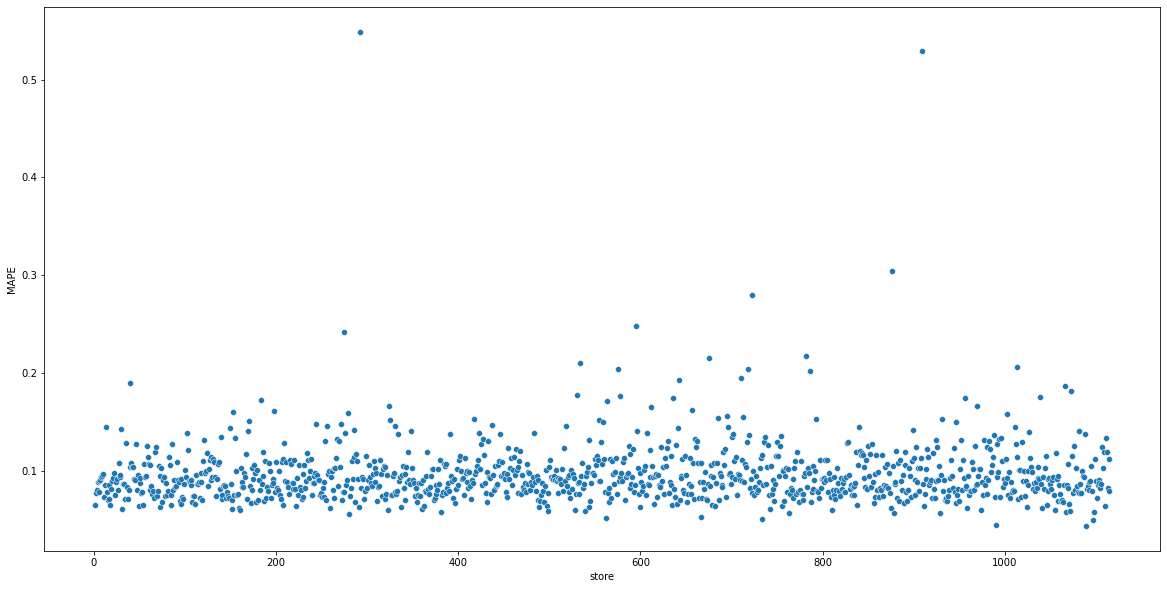

In [93]:
sns.scatterplot(x='store', y='MAPE', data= df92)

### 9.2 Total Performance (All Stores)

In [94]:
df93 = df92[['predictions', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis =0).reset_index().rename(columns ={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('USD {:,.2f} '.format)
df93

,Scenario,Values
0,predictions,"USD 285,041,664.00"
1,best_scenario,"USD 285,777,014.45"
2,worst_scenario,"USD 284,306,343.00"


### 9.3 Machine Learning Performance

In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gabrielredondoferrari/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='predictions', ylabel='error'>

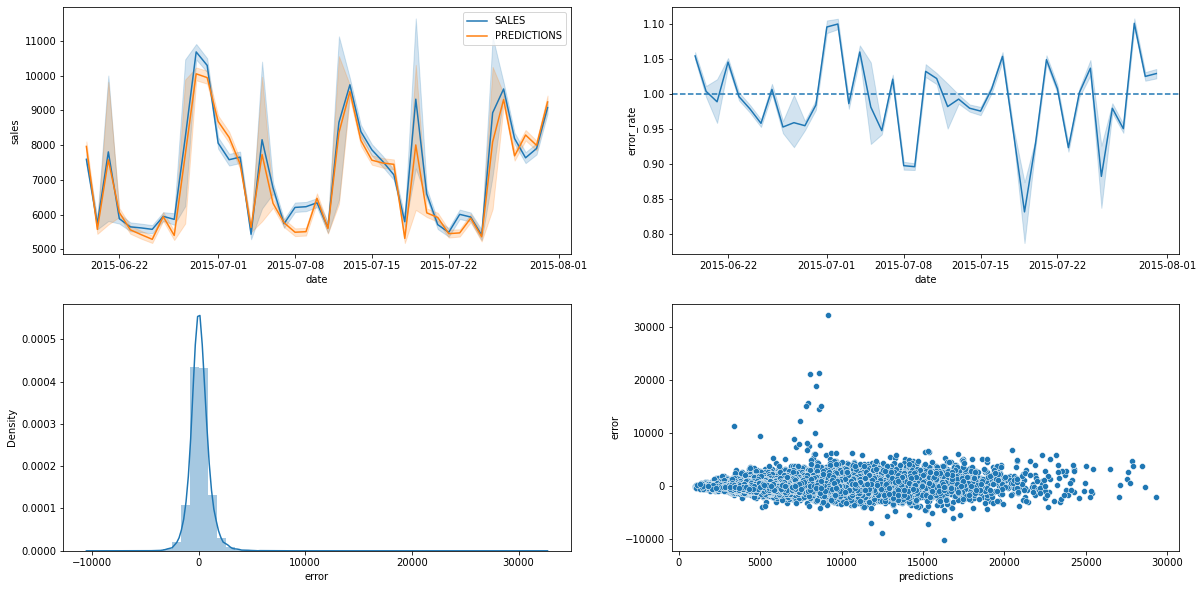

In [96]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 Deploy Model to Production

In [97]:
#Saving Trained Model
pickle.dump(model_xgb_tuned, open ('/Users/gabrielredondoferrari/DataScienceEmProducao/model/model_rossman.pkl', 'wb'))

### 10.1 Rossmann Class

In [101]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
class Rossmann (object):
    def __init__( self ):
        self.home_path = '/Users/gabrielredondoferrari/DataScienceEmProducao/'
        
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        
        self.store_tipe_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning( self, df1):
        
        

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new
        


        ### 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])




        ### 1.5 Fill Out NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x) 
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        return df1
    
    def feature_engineering(self, df2):
        #year
        df2['Year'] = df2['date'].dt.year

        #month
        df2['Month'] = df2['date'].dt.month

        #day
        df2['Day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'],month= x['competition_open_since_month'],day= 1), axis= 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c' else 'regular_day')
        
        ### 3.1 Rows Filtering

        df2 = df2[df2['open'] != 0]

        ### 3.2 Columns Selection

        cols_drop = ['promo_interval', 'open', 'month_map']
        df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation (self, df5):
        



        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['competition_time_month']].values)

        pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

        #year
        df5['Year'] = self.year_scaler.fit_transform(df5[['Year']].values)
        pickle.dump(rs, open('parameter/year_scaler.pkl', 'wb'))



        #### 5.3.1 Encoding

        #state_holiday - ONE HOT ENCODING(DUMMY)
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=["state_holiday"])

        #store type - LABEL ENCODING

        df5['store_type'] = self.store_tipe_scaler.fit_transform(df5['store_type'])



        #assortment - ORDINAL ENCODING
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        #### 5.3.3 Nature Transformation

        #month
        df5['month_sin'] = df5['Month'].apply(lambda x: np.sin (x* (2. * np.pi/12)))
        df5['month_cos'] = df5['Month'].apply(lambda x: np.cos (x* (2. * np.pi/12)))
        #day
        df5['day_sin'] = df5['Day'].apply(lambda x: np.sin (x* (2. * np.pi/30)))
        df5['day_cos'] = df5['Day'].apply(lambda x: np.cos (x* (2. * np.pi/30)))
        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x* (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x* (2. * np.pi/52)))
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x* (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x* (2. * np.pi/7)))
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join prediction into the original data
        original_data['prediction'] = np.expm1(pred)
        return original_data.to_json(orient='records', data_format = 'iso')

### 10.2 API Handler

In [103]:
import json
import pickle
import pandas as pd
from flask             import Flask, request, Response
from api.rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/gabrielredondoferrari/DataScienceEmProducao/model/model_rossman.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


### 10.3 API Tester

In [118]:
import requests
import json

In [119]:
#loading test dataset
df10 = pd.read_csv('/Users/gabrielredondoferrari/DataScienceEmProducao/data/test.csv')


In [120]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [121]:
#convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [131]:
#API CALL
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data
r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [132]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [133]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell USD {:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell USD 258,594.90 in the next 6 weeks
Store Number 22 will sell USD 232,669.56 in the next 6 weeks
Store Number 23 will sell USD 240,403.23 in the next 6 weeks
